In [32]:
# JSS
## TODO 
#using pca to reduce the dimensionality of the global descriptors
#using MobileVnet instead of netVLAD
#using hfnet instead of netVlAD and MobileVnet --that is not working 
# this will also help reduce the complexity 
#understand what superglue is outputting
# getting two models from SFM 
# Setting up the scale of the model -- this is done easy and simple
import numpy as np
import argparse
import yaml
import logging
from pathlib import Path
from tqdm import tqdm
from pprint import pformat
import h5py
import json
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# from notebooks.utils import plot_images, plot_matches, add_frame
from hfnet.models import get_model  

In [33]:
# send the path to the image directory and get the path to all the images in it
def image_directory_parser(path, viewer=True, number= 4):    
    globs=['*.jpg', '*.png', '*.jpeg', '*.JPG', '*.PNG']
    ## can also use sufix instead of with method
    image_path = []
    for g in globs:
        image_path += list(path.glob("**/"+g))
    print(len(image_path))
    if viewer:
        nrows = number
        ncols = number
        fig = plt.gcf()
        fig.set_size_inches(ncols*4, ncols*4)
        for i in range(2*number):
            sp = plt.subplot(nrows, ncols, i + 1)
            sp.axis('Off') # Don't show axes (or gridlines)
            img = mpimg.imread((image_path[i]))
            plt.imshow(img)
        plt.show()
    return image_path

In [34]:
def Trajectory5(path_to_json, skip=0):
	useful_filenames = path_to_json/"useful_filenames.json"
	useful_tvecs = path_to_json/"useful_tvecs.json"
	useful_rvecs = path_to_json/"useful_rvecs.json"
	with open(useful_rvecs) as f:
		rvecs = json.load(f)
	with open(useful_tvecs) as f:
		tvecs = json.load(f)
	with open(useful_filenames) as f:
		usefull_filenames = json.load(f)
	current_skip = 0
	from_useful = {}
	for i in tqdm(range(len(usefull_filenames))):
		if current_skip<skip:
			current_skip+=1
			continue
		current_skip = 0
		from_useful[usefull_filenames[i]]= {"tvecs": tvecs[i], "rvecs": rvecs[i]}
	return from_useful

In [35]:
path_to_images_for_map = Path('/home/Hierarchical-Localization/datasets/Trajectory5/skip9')

2003


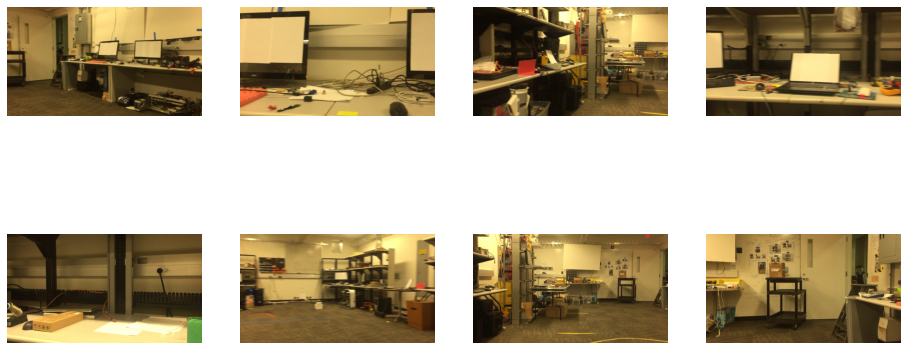

In [36]:
image_path = image_directory_parser(path_to_images_for_map, viewer=True, number = 4) 


In [37]:
path_to_json = Path('/home/Hierarchical-Localization/datasets/Trajectory5/UsefulPosesT5GS2')

In [38]:
using = Trajectory5(path_to_json, skip=9) ## this dict will always be the same 

100%|██████████| 20031/20031 [00:00<00:00, 1687578.66it/s]


In [39]:
## This funciton is diffrent in trajectory 5 because of the skip parameter
# image dictionary creator gives image, its name and index as dictionary
# def dictionary_of_images(image_path, using, path_to_images_for_map):
#     list_of_image = list(using.keys())
#     image_dict ={}
#     to_save = (path_to_images_for_map.parent)/"skip9"
#     index = 0
#     for i,j in tqdm(enumerate(image_path)):
#         if str(j.name) in list_of_image:
#             image_array = cv2.imread(str(j))
#     #         print(image_path[i].name)
#             image_to_save = to_save/j.name
#             copyfile(j,image_to_save)
#             image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
#             image_dict[index] = {"image":image_array, "name": image_path[i].name, "number": index}
#             index+=1
#     return image_dict
# image dictionary creator gives image, its name and index as dictionary
def dictionary_of_images(image_path):
    image_dict ={}
    for i,j in tqdm(enumerate(image_path)):
        image_array = cv2.imread(str(j))
#         print(image_path[i].name)
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
        image_dict[i] = {"image":image_array, "name": image_path[i].name, "number": i}
    return image_dict


In [40]:
image_dict = dictionary_of_images(image_path)
print(len(image_dict))

2003it [00:18, 105.51it/s]

2003


In [41]:
# this finds the global matrix and 
def global_dict_matrix_and_H5_map(config, image_dict):
    predictions_dict = {}
#     global_feature_path = (config["output"])/"global_features.h5"
#     global_feature_file = h5py.File(str(global_feature_path), 'w')
    checkpoint_path = Path(config["checkpoint_path"])
    keys = ['global_descriptor']    
    with get_model(config['model']['name'])(
            data_shape={'image': [None, None, None, 3]},
            **config['model']) as net:
        if checkpoint_path is not None:
            net.load(str(checkpoint_path))
        for i in tqdm(range(len(image_dict))):
            data = image_dict[i] ## selecting using index
            predictions = net.predict(data, keys=keys)
            predictions_dict[i] = {"global_descriptor":predictions['global_descriptor'], "name" : data['name']}   
            if i == 0:
                global_matrix = np.array(predictions['global_descriptor'])
            else:
                global_matrix = np.vstack((global_matrix,predictions['global_descriptor']))
#             grp = global_feature_file.create_group(data['name'])
#             grp.create_dataset('global_descriptor', data=predictions['global_descriptor'])
#         global_feature_file.close()
    return predictions_dict, global_matrix
def compute_distance(desc1, desc2):
    # For normalized descriptors, computing the distance is a simple matrix multiplication.
    return 2 * (1 - desc1 @ desc2.T)
## needs both global matrix and dict as we need to give names too
## I am idiot if I keep wiritng codes like this one lol ;)
# Need to change it hehehe
# Writing the .txt file.
def text_file_for_global_matches(global_feature_dict, global_feature_matrix, path, number): 
    predictions_dict_matches = {}
    for i in tqdm(range(len(global_feature_dict))):
        current_descriptor = global_feature_matrix[i, :]
        neighbours = compute_distance(current_descriptor, global_feature_matrix)
        predictions_dict_matches[i] = ((np.argsort(neighbours))[:number])[1 :]
    #first writing the file
    output_file_txt = path/"global_feature.txt"
    with open(output_file_txt, 'w') as f:
        for i in tqdm(range(len(predictions_dict_matches))):
            current_image_name = global_feature_dict[i]["name"]
            current_image_matches = predictions_dict_matches[i]
            string_list = []
            for j in range(len(current_image_matches)):
                    if i == 0 and j ==0:
                        making_a_string = current_image_name + " " + global_feature_dict[current_image_matches[j]]["name"]
                    
                    else: 
                        making_a_string = "\n" + current_image_name + " " + global_feature_dict[current_image_matches[j]]["name"]
                    f.write(making_a_string)  
    ## checking common lines and rewriting
    image_list_for_finding_common_separated = []
    with open(output_file_txt, 'r') as f:
        image_list_for_finding_common = [l.strip() for l in f]
    for i in range(len(image_list_for_finding_common)):
        current_index_value = image_list_for_finding_common[i]
        current_index_value = list(current_index_value.split(" "))
        image_list_for_finding_common_separated.append(sorted(current_index_value))
    ilf = sorted(image_list_for_finding_common_separated)
    final_list = []
    for i in range(len(ilf)):
        if ilf[i] in final_list:
            pass
        else:
            final_list.append(ilf[i])
    with open(output_file_txt, 'w') as f:
        for i in range(len(final_list)):
            if i == 0:
                making_a_string = final_list[i][0]+ " " + final_list[i][1]
            else:
                making_a_string = "\n" + final_list[i][0]+ " " + final_list[i][1]
            f.write(making_a_string)

In [42]:
output_path = Path("/home/Hierarchical-Localization/outputs/sfm_T5_skip_9")
# output_path.mkdir()
checkpoint_path = Path("/home/Hierarchical-Localization/weights/vd16_pitts30k_conv5_3_vlad_preL2_intra_white/vd16_pitts30k_conv5_3_vlad_preL2_intra_white")

In [43]:
config_global = {'output':output_path, 'checkpoint_path':checkpoint_path, 'data': {'name': 'aachen', 'load_db': False, 'load_queries': True, 'resize_max': 960}, 'model': {'name': 'netvlad_original', 'local_descriptor_layer': 'conv3_3', 'image_channels': 1}, 'weights': 'vd16_pitts30k_conv5_3_vlad_preL2_intra_white/vd16_pitts30k_conv5_3_vlad_preL2_intra_white'}         
global_dict_map, global_matrix = global_dict_matrix_and_H5_map(config_global, image_dict)

W0223 22:22:28.748119 140684893079360 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:104: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0223 22:22:28.764407 140684893079360 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:124: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0223 22:22:28.765099 140684893079360 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:124: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0223 22:22:28.766209 140684893079360 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:275: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0223 22:22:28.769431 140684893079360 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/h

In [19]:
"""
text_file_for_global_matches(global_dict_map, global_matrix,output_path,5
""" ## for creating the sfm model

'\ntext_file_for_global_matches(global_dict_map, global_matrix,output_path,5\n'

In [44]:
### Bringing in HLOC
%load_ext autoreload
%autoreload 2
from hloc import extract_features, match_features, reconstruction, visualization
feature_conf_superpoint = {'output': 'features_superpoint', 'model': {'name': 'superpoint', 'nms_radius': 3, 'max_keypoints': 4096}, 'preprocessing': {'grayscale': True, 'resize_max': 960}}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
"""
extract_features.main(feature_conf_superpoint,path_to_images_for_map,output_path)
"""

'\nextract_features.main(feature_conf_superpoint,path_to_images_for_map,output_path)\n'

In [45]:
matcher_conf = {'output': 'matches-superglue', 'model': {'name': 'superglue', 'weights': 'outdoor', 'sinkhorn_iterations': 50}}
features = feature_conf_superpoint['output']
sfm_pairs = output_path/"global_feature.txt"

In [23]:
"""
match_features.main(matcher_conf, sfm_pairs, features, output_path)

"""

'\nmatch_features.main(matcher_conf, sfm_pairs, features, output_path)\n\n'

In [46]:
sfm_dir = output_path/'sfm_superpoint+superglue'
feature_file = output_path/'features_superpoint.h5'
match_file = output_path/'features_superpoint_matches-superglue_global_feature.h5'

In [47]:
## check why the name given above is coming and change it
"""
reconstruction.main(
    sfm_dir,
    path_to_images_for_map,
    sfm_pairs,
    feature_file,
    match_file)
"""

'\nreconstruction.main(\n    sfm_dir,\n    path_to_images_for_map,\n    sfm_pairs,\n    feature_file,\n    match_file)\n'

In [26]:
### Set the map in global reference frame 
#number of images minimum =3
## creating the txt file
"""
def txt_file_for_geo_registration(output_path, using, number_of_images):
    file_name = 'output_world_file.txt'
    file_path = output_path/file_name
    using_list_keys = list(using.keys())
    with open(file_path, 'w') as f:    
        for i in range(number_of_images):
            image_name = using_list_keys[i]
            tvec = using[image_name]['tvecs']
            if i ==0:
                string = image_name+ " "+ str(tvec[0])+" "+ str(tvec[1])+" "+str(tvec[2])
            else:
                string = "\n" + image_name+ " "+str(tvec[0])+" "+ str(tvec[1])+" "+str(tvec[2])
            f.write(string)
"""

'\ndef txt_file_for_geo_registration(output_path, using, number_of_images):\n    file_name = \'output_world_file.txt\'\n    file_path = output_path/file_name\n    using_list_keys = list(using.keys())\n    with open(file_path, \'w\') as f:    \n        for i in range(number_of_images):\n            image_name = using_list_keys[i]\n            tvec = using[image_name][\'tvecs\']\n            if i ==0:\n                string = image_name+ " "+ str(tvec[0])+" "+ str(tvec[1])+" "+str(tvec[2])\n            else:\n                string = "\n" + image_name+ " "+str(tvec[0])+" "+ str(tvec[1])+" "+str(tvec[2])\n            f.write(string)\n'

In [27]:
"""
txt_file_for_geo_registration(output_path, using, 20)
"""

'\ntxt_file_for_geo_registration(output_path, using, 20)\n'

In [48]:
### geo registration model directory
sfm_dir = output_path/'sfm_superpoint+superglue'
geo_registration_dir = sfm_dir/"geo_registered_model"
if geo_registration_dir.exists() == False:
    geo_registration_dir.mkdir()


In [49]:
"""
import subprocess
cmd = ["colmap", "model_aligner",
       '--input_path', str(sfm_dir/"models"/"0"),
       '--output_path', str(geo_registration_dir),
       '--ref_images_path', str(output_path/'output_world_file.txt'),
       '--robust_alignment_max_error', str(20)]
"""

'\nimport subprocess\ncmd = ["colmap", "model_aligner",\n       \'--input_path\', str(sfm_dir/"models"/"0"),\n       \'--output_path\', str(geo_registration_dir),\n       \'--ref_images_path\', str(output_path/\'output_world_file.txt\'),\n       \'--robust_alignment_max_error\', str(20)]\n'

In [50]:
"""
subprocess.call(cmd)"""

'\nsubprocess.call(cmd)'

In [51]:
## find the error within itself
import os
import sys
import collections
import numpy as np
import struct
import argparse
BaseImage = collections.namedtuple(
    "Image", ["id", "qvec", "tvec", "camera_id", "name", "xys", "point3D_ids"])
class Image(BaseImage):
    def qvec2rotmat(self):
        return qvec2rotmat(self.qvec)
def read_images_binary(path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadImagesBinary(const std::string& path)
        void Reconstruction::WriteImagesBinary(const std::string& path)
    """
    images = {}
    with open(path_to_model_file, "rb") as fid:
        num_reg_images = read_next_bytes(fid, 8, "Q")[0]
        for image_index in range(num_reg_images):
            binary_image_properties = read_next_bytes(
                fid, num_bytes=64, format_char_sequence="idddddddi")
            image_id = binary_image_properties[0]
            qvec = np.array(binary_image_properties[1:5])
            tvec = np.array(binary_image_properties[5:8])
            camera_id = binary_image_properties[8]
            image_name = ""
            current_char = read_next_bytes(fid, 1, "c")[0]
            while current_char != b"\x00":   # look for the ASCII 0 entry
                image_name += current_char.decode("utf-8")
                current_char = read_next_bytes(fid, 1, "c")[0]
            num_points2D = read_next_bytes(fid, num_bytes=8,
                                           format_char_sequence="Q")[0]
            x_y_id_s = read_next_bytes(fid, num_bytes=24*num_points2D,
                                       format_char_sequence="ddq"*num_points2D)
            xys = np.column_stack([tuple(map(float, x_y_id_s[0::3])),
                                   tuple(map(float, x_y_id_s[1::3]))])
            point3D_ids = np.array(tuple(map(int, x_y_id_s[2::3])))
            images[image_name] = Image(
                id=image_id, qvec=qvec, tvec=tvec,
                camera_id=camera_id, name=image_name,
                xys=xys, point3D_ids=point3D_ids)
    return images
def read_next_bytes(fid, num_bytes, format_char_sequence, endian_character="<"):
    """Read and unpack the next bytes from a binary file.
    :param fid:
    :param num_bytes: Sum of combination of {2, 4, 8}, e.g. 2, 6, 16, 30, etc.
    :param format_char_sequence: List of {c, e, f, d, h, H, i, I, l, L, q, Q}.
    :param endian_character: Any of {@, =, <, >, !}
    :return: Tuple of read and unpacked values.
    """
    data = fid.read(num_bytes)
    return struct.unpack(endian_character + format_char_sequence, data)

In [52]:
def qvec2rotmat(qvec):
    return np.array([
        [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
         2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
         2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
        [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
         1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
         2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
        [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
         2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
         1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])
def colmap_to_global(_tvec, _qvec):
    return -np.matmul(qvec2rotmat(_qvec).transpose(), _tvec)

In [53]:
def global_and_colmap(name, read_images_binary, using):
    tvec = using[name]['tvecs']
    rvec = using[name]['rvecs']
    tvec_colmap = read_images_binary[name][2]
    rvec_colmap = read_images_binary[name][1]
    CtG= colmap_to_global(tvec_colmap, rvec_colmap)
    return tvec, CtG

In [54]:
def error(tvec, CtG):
    return np.linalg.norm(tvec-CtG)
    

In [55]:
image_bin_path = geo_registration_dir/"images.bin"
# ReadImagesBinary = read_images_binary(image_bin_path) ###not required now

In [56]:
def within_itself(using, ReadImagesBinary, path):
    list_of_registered = list(ReadImagesBinary.keys())
    file_name = 'with_itself_map_and_GT.txt'
    error_list = []
    with open(path/file_name, 'w') as f:        
        for i  in range(len(list_of_registered)):
            tvec, CtG = global_and_colmap(list_of_registered[i], ReadImagesBinary, using)
            err = error(tvec, CtG)
            error_list.append(err)
            if i == 0:
                string = list_of_registered[i]+ " " + str(tvec) + " " +str(CtG) + " " + str(err)
            else:
                string ='\n'+ list_of_registered[i]+ " " + str(tvec) + " " +str(CtG) + " " + str(err)
            f.write(string)
        error_list = np.asarray(error_list,  dtype=np.float32)
        string = '\n'+"The median error is "+ str(np.median(error_list))
        f.write(string)
        string = '\n'+"The mean error is "+ str(np.mean(error_list))
        f.write(string)
        string = '\n'+"The max error is "+ str(np.max(error_list))
        f.write(string)     

In [57]:
"""within_itself(using, ReadImagesBinary, output_path)"""

'within_itself(using, ReadImagesBinary, output_path)'

In [58]:
def creating_txt_file_for_localization(using, path):  ## params are hard coded need to change  + str(480)
    list_image_names = list(using.keys())
    filename = 'queries_with_in_itself_image_and_params.txt'
    with open(path/filename, 'w') as f:
        for i  in range(len(list_image_names)):
            if i == 0:
                string = list_image_names[i] + " "+ "SIMPLE_RADIAL"+ " " +str(640)+ " "+ str(480)+" " + str(658.503)+ " "+str(320)+ " " + str(180) + " "+str(0.0565491)
            else:
                string = "\n"+  list_image_names[i] + " "+ "SIMPLE_RADIAL"+ " " +str(640)+ " "+ str(480)+" " + str(658.503)+ " "+str(320)+ " " + str(180) + " "+str(0.0565491)
            f.write(string)

In [39]:
### Will have to do single image localization in the case of self localization as 
## the global descriptors are giving a problem 35_center

In [60]:
path_to_query = Path("/home/Hierarchical-Localization/datasets/Trajectory3/choosen_testing")
# path_to_mask = Path("/home/Hierarchical-Localization/datasets/Trajectory3/Image_added_scale_0.35_center_grey")
global_file_txt = "global_image_choosen.txt"
# feature_conf_superpoint_query_name = 'features_superpoint_T3_Image_added_scale_0.35_grey'
# matcher_conf_query_name = 'matches-superglue_T3_Image_added_scale_0.35_grey'
# feat_name = feature_conf_superpoint_query_name+".h5"
# mat_name = 'features_superpoint_matches-superglue_T3_Image_added_scale_0.35_grey_Image_added_scale_0.35_grey.h5'
res_name = "Image_added_scale_0.35_grey_T3results.txt"
res_name_err =  "Image_added_scale_0.35_grey_T3results_err.txt"

In [61]:
image_path_query = image_directory_parser(path_to_query, viewer=False, number = 4) 

10


In [62]:
image_dict_query = dictionary_of_images(image_path_query)

10it [00:00, 92.66it/s]


In [64]:
def global_dict_matrix_query(config, image_dict):
    predictions_dict = {}
    checkpoint_path = Path(config["checkpoint_path"])
    keys = ['global_descriptor']    
    with get_model(config['model']['name'])(
            data_shape={'image': [None, None, None, 3]},
            **config['model']) as net:
        if checkpoint_path is not None:
            net.load(str(checkpoint_path))
        for i in tqdm(range(len(image_dict))):
            data = image_dict[i] ## selecting using index
            predictions = net.predict(data, keys=keys)
            predictions_dict[i] = {"global_descriptor":predictions['global_descriptor'], "name" : data['name']}   
            if i == 0:
                global_matrix = np.array(predictions['global_descriptor'])
            else:
                global_matrix = np.vstack((global_matrix,predictions['global_descriptor']))
    return predictions_dict, global_matrix

In [65]:
predicitons_dict_query, global_matric_query = global_dict_matrix_query(config_global, image_dict_query)

I0223 22:38:37.376231 140684893079360 saver.py:1280] Restoring parameters from /home/Hierarchical-Localization/weights/vd16_pitts30k_conv5_3_vlad_preL2_intra_white/vd16_pitts30k_conv5_3_vlad_preL2_intra_white
100%|██████████| 10/10 [00:00<00:00, 18.50it/s]


In [67]:
def query_global_txt_file_creator(image_dict_query, image_dict_map, global_matrix, predictions_dict_query, path, file_name, number):
    with open(path/file_name, 'w') as f:
        for i in tqdm(range(len(predictions_dict_query))):
            current_descriptor = predictions_dict_query[i]["global_descriptor"]
            neighbours = compute_distance(current_descriptor, global_matrix)
            global_matches = ((np.argsort(neighbours))[:number])
            for j in range(len(global_matches)):
                if i == 0 and j ==0:
                    string = image_dict_query[i]["name"]+ " "+ image_dict_map[global_matches[j]]["name"]
                else:
                    string = "\n"+ image_dict_query[i]["name"]+ " "+ image_dict_map[global_matches[j]]["name"]
                f.write(string) 

In [68]:
query_global_txt_file_creator(image_dict_query, image_dict, global_matrix, predicitons_dict_query, output_path, global_file_txt, 10)

100%|██████████| 10/10 [00:00<00:00, 447.81it/s]


In [69]:
feature_conf_superpoint_query = {'output': 'choosen_local_feature', 'model': {'name': 'superpoint', 'nms_radius': 3, 'max_keypoints': 4096}, 'preprocessing': {'grayscale': True, 'resize_max': 960}}


In [71]:
from hloc import extract_features

In [72]:
extract_features.main(feature_conf_superpoint_query,path_to_query,output_path)


I0223 22:42:32.119246 140684893079360 extract_features.py:123] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'choosen_local_feature',
 'preprocessing': {'grayscale': True, 'resize_max': 960}}
I0223 22:42:32.172412 140684893079360 extract_features.py:81] Found 10 images in root /home/Hierarchical-Localization/datasets/Trajectory3/choosen_testing.
  0%|          | 0/10 [00:00<?, ?it/s]

Loaded SuperPoint model


100%|██████████| 10/10 [00:00<00:00, 15.47it/s]
I0223 22:42:32.826402 140684893079360 extract_features.py:160] Finished exporting features.


In [73]:
matcher_conf_query = {'output': 'choosen_matches', 'model': {'name': 'superglue', 'weights': 'outdoor', 'sinkhorn_iterations': 50}}
features_query = feature_conf_superpoint_query['output']
loc_pairs = output_path/global_file_txt

In [74]:
from hloc import feature_matcher_map_query

In [75]:
feature_matcher_map_query.main(matcher_conf_query, loc_pairs, features, output_path, features_query)

I0223 22:43:06.269637 140684893079360 feature_matcher_map_query.py:42] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'choosen_matches'}
I0223 22:43:06.271351 140684893079360 feature_matcher_map_query.py:50] Using query_features choosen_local_feature
  0%|          | 0/100 [00:00<?, ?it/s]

Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 100/100 [00:05<00:00, 17.89it/s]
I0223 22:43:12.160654 140684893079360 feature_matcher_map_query.py:127] Finished exporting matches.


In [77]:
"""filename = "queries_choosen_with_intrinsics.txt"
with open(output_path/filename, 'w') as f:
    for i in range(len(image_path_query)):
        name = image_path_query[i].name
        if i ==0:
            string = str(name) + " "+ "SIMPLE_RADIAL"+ " " +str(640)+ " "+ str(480)+" " + str(658.503)+ " "+str(320)+ " " + str(180) + " "+str(0.0565491)
        else:
            string = "\n"+  str(name) + " "+ "SIMPLE_RADIAL"+ " " +str(640)+ " "+ str(480)+" " + str(658.503)+ " "+str(320)+ " " + str(180) + " "+str(0.0565491)
        f.write(string)  """        

'filename = "queries_choosen_with_intrinsics.txt"\nwith open(output_path/filename, \'w\') as f:\n    for i in range(len(image_path_query)):\n        name = image_path_query[i].name\n        if i ==0:\n            string = str(name) + " "+ "SIMPLE_RADIAL"+ " " +str(640)+ " "+ str(480)+" " + str(658.503)+ " "+str(320)+ " " + str(180) + " "+str(0.0565491)\n        else:\n            string = "\n"+  str(name) + " "+ "SIMPLE_RADIAL"+ " " +str(640)+ " "+ str(480)+" " + str(658.503)+ " "+str(320)+ " " + str(180) + " "+str(0.0565491)\n        f.write(string)  '

In [78]:
from hloc import localize_sfm
localize_sfm.main(geo_registration_dir,
                 output_path/"queries_choosen_with_intrinsics.txt",
                 loc_pairs,
                 output_path/'choosen_local_feature.h5',
                 output_path/'features_superpoint_choosen_matches_global_image_choosen.h5',
                 output_path/'results_choosen.txt',
                 covisibility_clustering=False)


I0223 22:45:59.291900 140684893079360 parsers.py:16] Importing 10 queries in queries_choosen_with_intrinsics.txt
I0223 22:45:59.293802 140684893079360 localize_sfm.py:110] Reading 3D model...
I0223 22:46:01.647834 140684893079360 localize_sfm.py:124] Starting localization...
 20%|██        | 2/10 [00:00<00:00, 15.50it/s]

float64
float64
float64
float64


 70%|███████   | 7/10 [00:00<00:00, 20.50it/s]

float64
float64
float64
float64
float64


100%|██████████| 10/10 [00:00<00:00, 19.38it/s]
I0223 22:46:02.166972 140684893079360 localize_sfm.py:188] Localized 10 / 10 images.
I0223 22:46:02.167822 140684893079360 localize_sfm.py:189] Writing poses to /home/Hierarchical-Localization/outputs/sfm_T5_skip_9/results_choosen.txt...
I0223 22:46:02.170013 140684893079360 localize_sfm.py:199] Writing logs to /home/Hierarchical-Localization/outputs/sfm_T5_skip_9/results_choosen.txt_logs.pkl...
I0223 22:46:02.197180 140684893079360 localize_sfm.py:202] Done!


float64


In [80]:
from hloc import  visualization

In [81]:
local_feature_path = output_path/'features_superpoint.h5'
local_feature_path_query = output_path/'choosen_local_feature.h5'

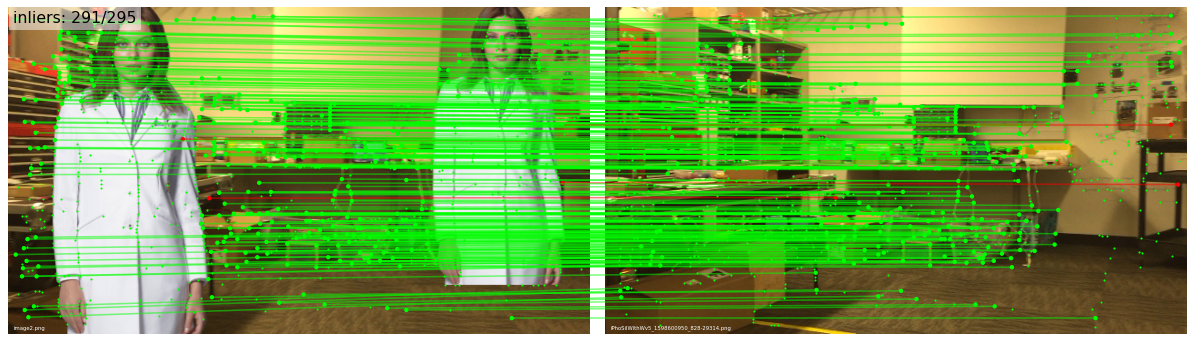

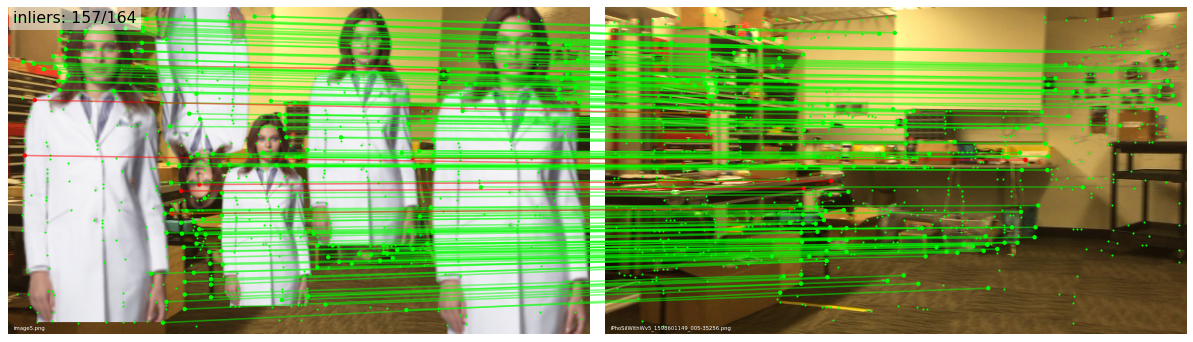

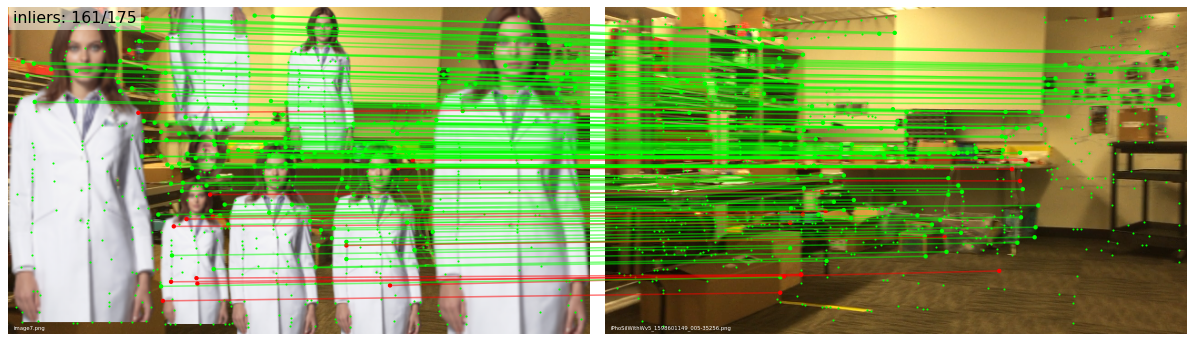

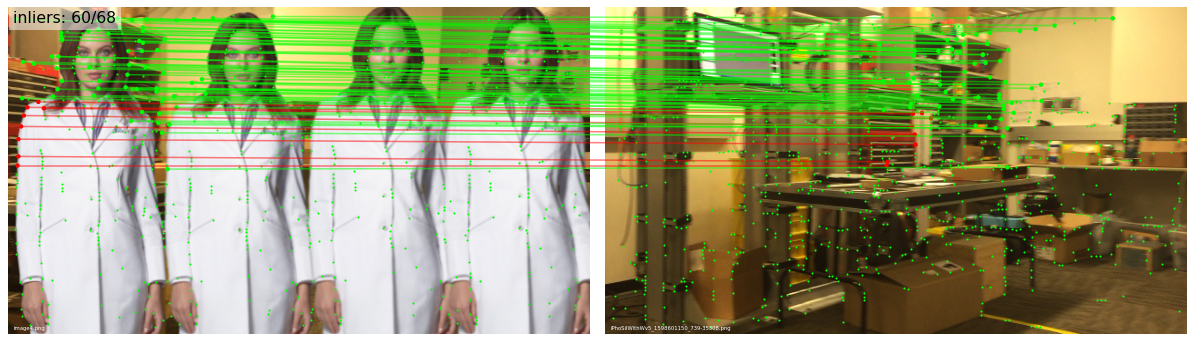

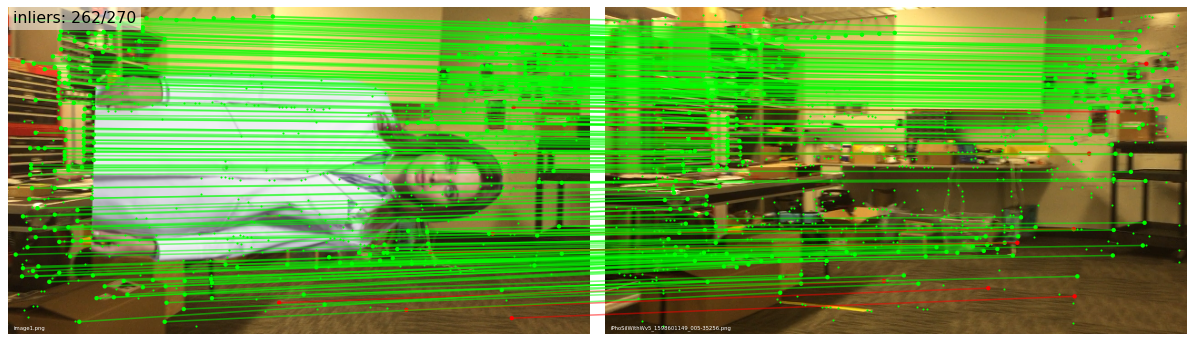

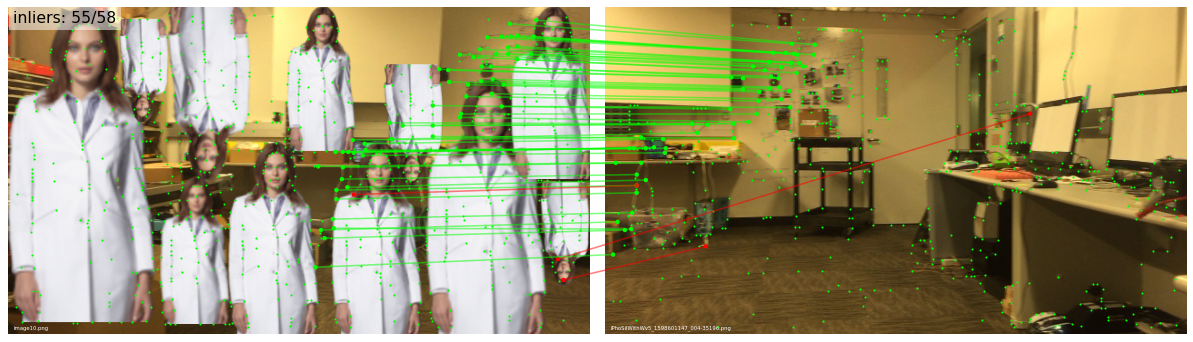

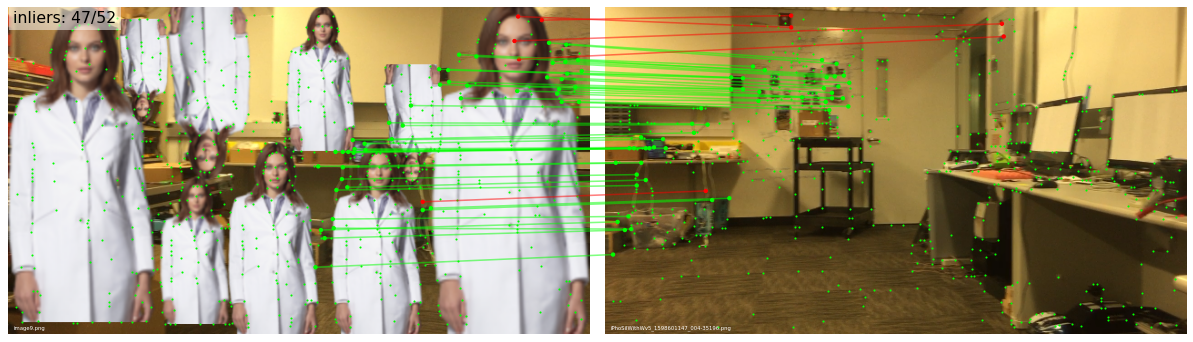

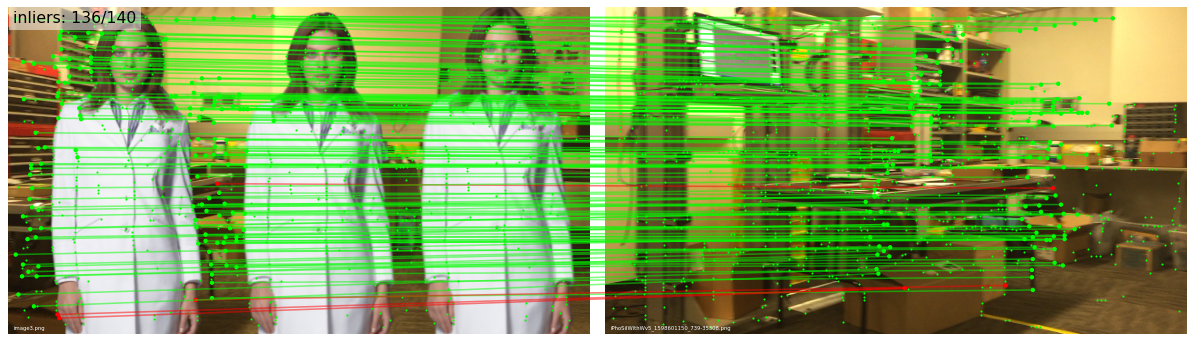

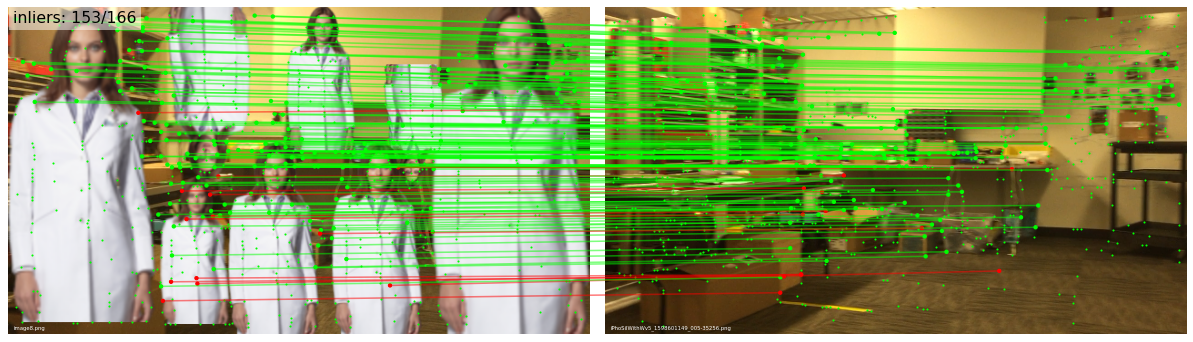

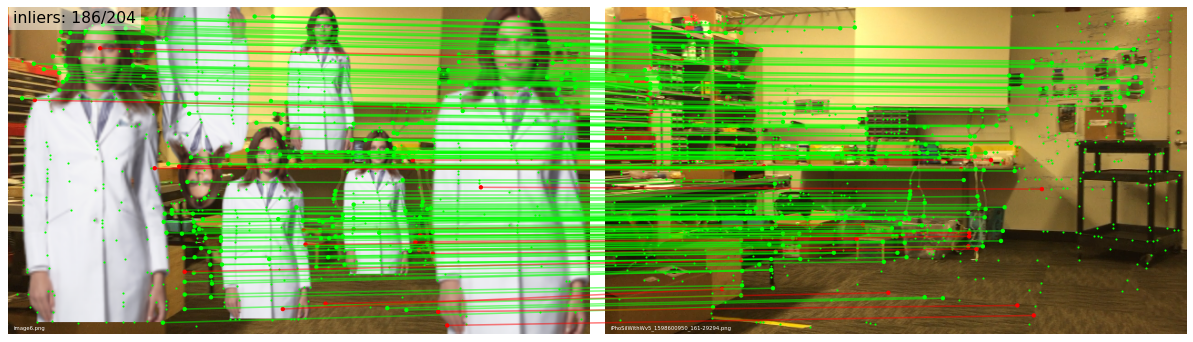

In [84]:
visualization.visualize_loc_new(
    output_path/'results_choosen.txt', path_to_images_for_map,path_to_query,local_feature_path, local_feature_path_query, geo_registration_dir , n=10, top_k_db=1, seed=2)

In [183]:
import jsonparser

In [184]:
names_trans_rot = jsonparser.parser("/home/Hierarchical-Localization/datasets/Trajectory3/UsefulPoses")

In [185]:
def file_creator_error(original_dict_json, file_name_read, file_name_write, path):
    list_of_registered = list(original_dict_json.keys())
    with open(path/file_name_read, 'r') as f:
        Lines = f.readlines()
    error_list = []
    with open(path/file_name_write, 'w') as f:
        for line in Lines:
            line = line.split()
            name = line[0]
            qvec = np.asarray(line[1:5], dtype=np.float32)
#             qvec = np.array([line[2], line[3], line[4], line[1]],dtype=np.float32)
            tvec = np.asarray(line[5:8], dtype=np.float32)
            tvec_world = colmap_to_global(tvec, qvec)
            tvec_ori = original_dict_json[name]["tvec"]
            er =  error(tvec_world, tvec_ori)
            error_list.append(er)
            string = name + " "+ str(tvec_ori)+ " "+str(tvec_world)+ " " + str(er)+ "\n"
            f.write(string)
        error_list = np.asarray(error_list,  dtype=np.float32)
        string = "The median error is "+ str(np.median(error_list))+ '\n'
        f.write(string)
        string = "The mean error is "+ str(np.mean(error_list))+ '\n'
        f.write(string)
        string = "The max error is "+ str(np.max(error_list))
        f.write(string)

In [186]:
file_creator_error(names_trans_rot,res_name, res_name_err, output_path)